# Imports

In [1]:
import os
import sys

from IPython.display import Video
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# change working directory to the root of the project
if os.getcwd().split('/')[-1] == 'test':
    os.chdir('..')

import config
import data
import models

# Testing bounding box transformation

In [3]:
# test bbox transform with a list of bboxes
bboxes = [
    {
        "x": 200,
        "y": 200,
        "time": 0,
        "frame": 0,
        "width": 100,
        "height": 100,
        "rotation": 0,
    },
    {
        "x": 100,
        "y": 100,
        "time": 10,
        "frame": 100,
        "width": 200,
        "height": 200,
        "rotation": 30,
    }
]

In [4]:
transforms = models.MViT_V2_S_Weights.DEFAULT.transforms()
dataset = data.VideoDataset(
        config.TRAIN_ANNOTATION_FILE,
        config.DATA_DIRECTORY,
        fps=7.5,
        # transform=transforms,
        # transforms(
        # data.expand_video_into_batches(x, batch_size=16, stride=8, device=device)
        # ),
        target_transform=lambda x: data.expand_label(x, 1, device=device),
    ),

In [5]:
sample = dataset[0][0][0]
print(sample.shape)

torch.Size([156, 3, 480, 640])


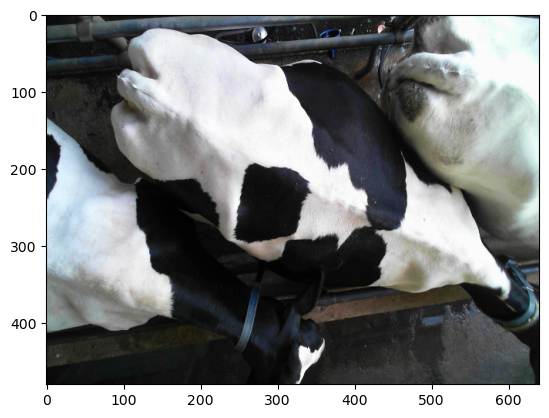

In [6]:
# show frame
plt.imshow(sample.permute(0, 2, 3, 1)[0])

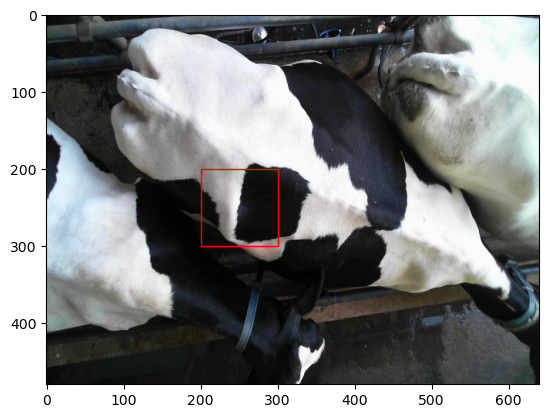

In [7]:
# show frame with bboxes[0]
plt.imshow(sample.permute(0, 2, 3, 1)[0])
plt.gca().add_patch(plt.Rectangle((bboxes[0]["x"], bboxes[0]["y"]), bboxes[0]["width"], bboxes[0]["height"], linewidth=1, edgecolor='r', facecolor='none'))

In [8]:
# transform frame with bbox
transformed_sample = data.bounding_box_transform(sample, bboxes = bboxes)

/home/andrems2305/anaconda3/envs/breathing/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
# Save transformed sample to mp4 file
torchvision.io.write_video("test/out/test.mp4", transformed_sample.permute(0, 2, 3, 1), fps=7.5)

In [10]:
# show video
Video("test/out/test.mp4", embed=True)

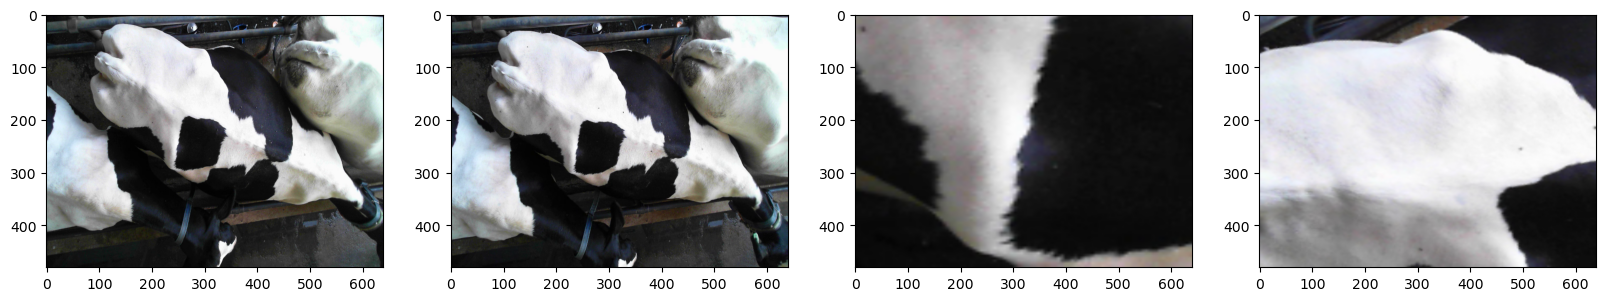

In [11]:
# show four frames (first, last, first transformed, last transformed)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(sample.permute(0, 2, 3, 1)[0])
axs[1].imshow(sample.permute(0, 2, 3, 1)[-1])
axs[2].imshow(transformed_sample.permute(0, 2, 3, 1)[0])
axs[3].imshow(transformed_sample.permute(0, 2, 3, 1)[-1])
plt.show()

# Testing bounding box transformation with Label Studio's labels


## Loading data

In [12]:
json_filename = "project-6-at-2023-07-17-15-08-b48ff462.json"
# Load json file
df = pd.read_json(json_filename)
# filter annotations with bboxes
df = df.loc[df["id"].isin([5007, 5008, 5009, 5010, 5011, 5012]), :]
# Get annotations of each video and append as columns (rows when more than one annotation)
df = pd.concat(
    [
        df,
        pd.json_normalize(df.set_index("id")["annotations"])
        .set_index(df.index)
        .add_prefix("annotations."),
    ],
    axis=1,
)
# Drop annotations column
df = df.drop(columns=["annotations"])
print(df.shape)
print(df.columns)
# Melt annotations columns into rows
df = df.melt(
    id_vars=[col for col in df.columns if not col.startswith("annotations.")],
    value_vars=[col for col in df.columns if col.startswith("annotations.")],
    var_name="annotation",
    value_name="value",
)
# Remove temporary prefix
df["annotation"] = df["annotation"].str.replace("annotations.", "")
print(df.shape)
print(df.columns)
# Get annotation values of each annotation and append as columns (rows when more than one annotation)
df = pd.concat(
    [
        df,
        pd.json_normalize(df.set_index("id")["value"])
        .set_index(df.index)
        .add_prefix("annotation."),
    ],
    axis=1,
)
# Drop value column
df = df.drop(columns=["value"])
print(df.shape)
print(df.columns)
# Melt annotation columns into rows
df = df.melt(
    id_vars=[col for col in df.columns if not col.endswith("result")],
    value_vars=[col for col in df.columns if col.endswith("result")],
    var_name="annotation_value",
    value_name="value",
)
# Remove temporary prefix
df["annotation_value"] = df["annotation_value"].str.replace("annotation.", "")
print(df.shape)
print(df.columns)
# For each row, get video segments and append as columns (rows when more than one segment)
for i, row in df.iterrows():
    new_rows = []
    segments = pd.json_normalize(
        [segment for segment in row["value"] if segment["type"] == "labels"]
    ).add_prefix("segment.")
    # concatenate each segment as a row to the dataframe
    # keep row's columns and add segment's columns
    for j, segment in segments.iterrows():
        new_rows.append(pd.concat([row, segment], axis=0))
    # remove row
    df = df.drop(i)
    # concatenate new rows
    df = pd.concat([df, pd.DataFrame(new_rows)], axis=0)
# Reset index
df = df.reset_index(drop=True)
print(df.shape)
print(df.columns)

(6, 19)
Index(['id', 'file_upload', 'drafts', 'predictions', 'data', 'meta',
       'created_at', 'updated_at', 'inner_id', 'total_annotations',
       'cancelled_annotations', 'total_predictions', 'comment_count',
       'unresolved_comment_count', 'last_comment_updated_at', 'project',
       'updated_by', 'comment_authors', 'annotations.0'],
      dtype='object')
(6, 20)
Index(['id', 'file_upload', 'drafts', 'predictions', 'data', 'meta',
       'created_at', 'updated_at', 'inner_id', 'total_annotations',
       'cancelled_annotations', 'total_predictions', 'comment_count',
       'unresolved_comment_count', 'last_comment_updated_at', 'project',
       'updated_by', 'comment_authors', 'annotation', 'value'],
      dtype='object')
(6, 36)
Index(['id', 'file_upload', 'drafts', 'predictions', 'data', 'meta',
       'created_at', 'updated_at', 'inner_id', 'total_annotations',
       'cancelled_annotations', 'total_predictions', 'comment_count',
       'unresolved_comment_count', 'last_co

In [13]:
pd.set_option('display.max_columns', None)
df

id                   file_upload drafts predictions  \
0   5007  725e00cf-video15T_3_t029.mp4     []          []   
1   5007  725e00cf-video15T_3_t029.mp4     []          []   
2   5007  725e00cf-video15T_3_t029.mp4     []          []   
3   5008  de86bd9a-video15T_3_t028.mp4     []          []   
4   5008  de86bd9a-video15T_3_t028.mp4     []          []   
5   5009  71adced1-video15T_3_t027.mp4     []          []   
6   5010  8c55932b-video15T_3_t026.mp4     []          []   
7   5010  8c55932b-video15T_3_t026.mp4     []          []   
8   5011  d427f50b-video15T_3_t025.mp4     []          []   
9   5011  d427f50b-video15T_3_t025.mp4     []          []   
10  5012  f3ce3ae8-video15T_3_t021.mp4     []          []   
11  5012  f3ce3ae8-video15T_3_t021.mp4     []          []   

                                                 data meta  \
0   {'video': '/data/upload/6/725e00cf-video15T_3_...   {}   
1   {'video': '/data/upload/6/725e00cf-video15T_3_...   {}   
2   {'video': '/data/upload/6/725e00cf-video15T_3_...   {}   
3   {'video': '/data/upload/6/de86bd9a-video15T_3_...   {}   
4   {'video': '/data/upload/6/de86bd9a-video15T_3_...   {}   
5   {'video': '/data/upload/6/71adced1-video15T_3_...   {}   
6   {'video': '/data/upload/6/8c55932b-video15T_3_...   {}   
7   {'video': '/data/upload/6/8c55932b-video15T_3_...   {}   
8   {'video': '/data/upload/6/d427f50b-video15T_3_...   {}   
9   {'video': '/data/upload/6/d427f50b-video15T_3_...   {}   
10  {'video': '/data/upload/6/f3ce3ae8-video15T_3_...   {}   
11  {'video': '/data/upload/6/f3ce3ae8-video15T_3_...   {}   

                         created_at                       updated_at  \
0  2023-05-31 13:37:10.324838+00:00 2023-07-03 19:16:04.130599+00:00   
1  2023-05-31 13:37:10.324838+00:00 2023-07-03 19:16:04.130599+00:00   
2  2023-05-31 13:37:10.324838+00:00 2023-07-03 19:16:04.130599+00:00   
3  2023-05-31 13:37:10.324885+00:00 2023-07-03 19:16:26.261425+00:00   
4  2023-05-31 13:37:10.324885+00:00 2023-07-03 19:16:26.261425+00:00   
5  2023-05-31 13:37:10.324930+00:00 2023-07-03 19:16:41.404338+00:00   
6  2023-05-31 13:37:10.324975+00:00 2023-07-03 19:17:20.801441+00:00   
7  2023-05-31 13:37:10.324975+00:00 2023-07-03 19:17:20.801441+00:00   
8  2023-05-31 13:37:10.325020+00:00 2023-07-03 19:17:38.100736+00:00   
9  2023-05-31 13:37:10.325020+00:00 2023-07-03 19:17:38.100736+00:00   
10 2023-05-31 13:37:10.325066+00:00 2023-07-03 19:18:18.910600+00:00   
11 2023-05-31 13:37:10.325066+00:00 2023-07-03 19:18:18.910600+00:00   

    inner_id  total_annotations  cancelled_annotations  total_predictions  \
0          3                  1                      0                  0   
1          3                  1                      0                  0   
2          3                  1                      0                  0   
3          4                  1                      0                  0   
4          4                  1                      0                  0   
5          5                  1                      0                  0   
6          6                  1                      0                  0   
7          6                  1                      0                  0   
8          7                  1                      0                  0   
9          7                  1                      0                  0   
10         8                  1                      0                  0   
11         8                  1                      0                  0   

    comment_count  unresolved_comment_count last_comment_updated_at  project  \
0               0                         0                     NaT        6   
1               0                         0                     NaT        6   
2               0                         0                     NaT        6   
3               0                         0                     NaT        6   
4               0                         0                     Na

## Testing finished functions

In [14]:
data.load_label_studio_annotations(
    json_filename,
    filter_ids=[5007, 5008, 5009, 5010, 5011, 5012],
)

id                   file_upload drafts predictions  \
0   5007  725e00cf-video15T_3_t029.mp4     []          []   
1   5007  725e00cf-video15T_3_t029.mp4     []          []   
2   5007  725e00cf-video15T_3_t029.mp4     []          []   
3   5008  de86bd9a-video15T_3_t028.mp4     []          []   
4   5008  de86bd9a-video15T_3_t028.mp4     []          []   
6   5010  8c55932b-video15T_3_t026.mp4     []          []   
7   5010  8c55932b-video15T_3_t026.mp4     []          []   
8   5011  d427f50b-video15T_3_t025.mp4     []          []   
9   5011  d427f50b-video15T_3_t025.mp4     []          []   
10  5012  f3ce3ae8-video15T_3_t021.mp4     []          []   
11  5012  f3ce3ae8-video15T_3_t021.mp4     []          []   

                                                 data meta  \
0   {'video': '/data/upload/6/725e00cf-video15T_3_...   {}   
1   {'video': '/data/upload/6/725e00cf-video15T_3_...   {}   
2   {'video': '/data/upload/6/725e00cf-video15T_3_...   {}   
3   {'video': '/data/upload/6/de86bd9a-video15T_3_...   {}   
4   {'video': '/data/upload/6/de86bd9a-video15T_3_...   {}   
6   {'video': '/data/upload/6/8c55932b-video15T_3_...   {}   
7   {'video': '/data/upload/6/8c55932b-video15T_3_...   {}   
8   {'video': '/data/upload/6/d427f50b-video15T_3_...   {}   
9   {'video': '/data/upload/6/d427f50b-video15T_3_...   {}   
10  {'video': '/data/upload/6/f3ce3ae8-video15T_3_...   {}   
11  {'video': '/data/upload/6/f3ce3ae8-video15T_3_...   {}   

                         created_at                       updated_at  \
0  2023-05-31 13:37:10.324838+00:00 2023-07-03 19:16:04.130599+00:00   
1  2023-05-31 13:37:10.324838+00:00 2023-07-03 19:16:04.130599+00:00   
2  2023-05-31 13:37:10.324838+00:00 2023-07-03 19:16:04.130599+00:00   
3  2023-05-31 13:37:10.324885+00:00 2023-07-03 19:16:26.261425+00:00   
4  2023-05-31 13:37:10.324885+00:00 2023-07-03 19:16:26.261425+00:00   
6  2023-05-31 13:37:10.324975+00:00 2023-07-03 19:17:20.801441+00:00   
7  2023-05-31 13:37:10.324975+00:00 2023-07-03 19:17:20.801441+00:00   
8  2023-05-31 13:37:10.325020+00:00 2023-07-03 19:17:38.100736+00:00   
9  2023-05-31 13:37:10.325020+00:00 2023-07-03 19:17:38.100736+00:00   
10 2023-05-31 13:37:10.325066+00:00 2023-07-03 19:18:18.910600+00:00   
11 2023-05-31 13:37:10.325066+00:00 2023-07-03 19:18:18.910600+00:00   

    inner_id  total_annotations  cancelled_annotations  total_predictions  \
0          3                  1                      0                  0   
1          3                  1                      0                  0   
2          3                  1                      0                  0   
3          4                  1                      0                  0   
4          4                  1                      0                  0   
6          6                  1                      0                  0   
7          6                  1                      0                  0   
8          7                  1                      0                  0   
9          7                  1                      0                  0   
10         8                  1                      0                  0   
11         8                  1                      0                  0   

    comment_count  unresolved_comment_count last_comment_updated_at  project  \
0               0                         0                     NaT        6   
1               0                         0                     NaT        6   
2               0                         0                     NaT        6   
3               0                         0                     NaT        6   
4               0                         0                     NaT        6   
6               0                         0                     NaT        6   
7               0                         0                     NaT        6   
8               0                         0                     NaT        6   
9               0 

In [15]:
dataset = data.VideoDataset(
        json_filename,
        config.DATA_DIRECTORY,
        fps=7.5,
        # transform=transforms,
        # transforms(
        # data.expand_video_into_batches(x, batch_size=16, stride=8, device=device)
        # ),
        target_transform=lambda x: data.expand_label(x, 1, device=device),
        filter_ids=[5007, 5008, 5009, 5010, 5011, 5012],
    ),

In [16]:
sample, label = dataset[0][0]
torchvision.io.write_video("test/out/test.mp4", sample.permute(0, 2, 3, 1), fps=5.0)

/home/andrems2305/anaconda3/envs/breathing/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [17]:
Video("test/out/test.mp4", embed=True)